# Kuramoto-Shinomoto-Sakaguchi MKV-SDE

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy import linalg as LA
from numpy import mean
from tabulate import tabulate
import mlflow
from itertools import product

In [2]:
def monte_carlo(sigma, T, N, M, X0):

    h = T / N
    X = X0 * np.ones(M)
    gamma1, gamma2 = np.zeros(N+1), np.zeros(N+1)
    gamma1[0], gamma2[0] = mean(np.sin(X)), mean(np.cos(X))

    for i in range(N):
        W = np.random.normal(0, 1, M)
        X = X + (gamma1[i] * np.cos(X) - gamma2[i] * np.sin(X)) * h + sigma * math.sqrt(h) * W
        gamma1[i+1], gamma2[i+1] = mean(np.sin(X)), mean(np.cos(X))

    return X, gamma1, gamma2

def base(T, N, n, X0, tipo):

    g = np.ones(n+1)
    cc = np.linspace(0, T, N+1)

    if tipo == 'canonical':

        g = np.array([ cc ** i for i in range(n+1)])
        a1_0, a2_0 = np.sin(X0) * g[:,0], np.cos(X0) * g[:,0]

        return a1_0, a2_0, g

    elif tipo == 'lagrange':

        l = [(0 + T)/2 + (T - 0)/2 * np.cos(((2 * i + 1)/ (2 * n + 2)) * math.pi) for i in range(n+1)]
        g = np.array([math.prod([((cc - l[j]) / (l[i] - l[j])) for j in range(n+1) if j!=i]) for i in range(n+1)])
        a1_0, a2_0 = np.sin(X0) * np.ones(n+1), np.cos(X0) * np.ones(n+1)

        return a1_0, a2_0, g

    else:
        return 'err'

def euler(a1, a2, sigma, n, N, M, Z0, h, g):

    X, Z = Z0 * np.ones((N+1, M)), Z0 * np.ones((N+1, M))
    Y1, Y2 = np.zeros((N+1, n+1, M)), np.zeros((N+1, n+1, M))

    for i in range(N):
        c1, c2 = np.dot(a1, g[:,i]), np.dot(a2, g[:,i])

        W = np.random.normal(0, 1, (2, M))

        X[i+1] = X[i] + (c1 * np.cos(X[i]) - c2 * np.sin(X[i])) * h + sigma * math.sqrt(h) * W[0]

        term = c1 * np.sin(Z[i]) + c2 * np.cos(Z[i])
        Y1[i+1] = Y1[i] + (np.tile(g[:,i],(M, 1)).transpose() * np.cos(Z[i]) - Y1[i] * (term)) * h
        Y2[i+1] = Y2[i] + (-np.tile(g[:,i],(M, 1)).transpose() * np.sin(Z[i]) - Y2[i] * (term)) * h

        Z[i+1] = Z[i] + (c1 * np.cos(Z[i]) - c2 * np.sin(Z[i])) * h + sigma * math.sqrt(h) * W[1]

    return X, Z, Y1, Y2

def stochastic_gradient_descent(a1_0, a2_0, n, r0, rho, sigma, N, M, X0, eps, h, g, gamma1, gamma2): #, K, tau):

    a1, a2 = a1_0, a2_0
    norm1, norm2 = LA.norm(gamma1), LA.norm(gamma2)
    deLa = np.tile(g.transpose()[:, :, np.newaxis], (1, 1, M))

    for m in range(5000):

        if ( ((LA.norm(np.dot(a1,g) - gamma1)/ norm1) < eps) and ((LA.norm(np.dot(a2,g) - gamma2)/ norm2) < eps) ):
                break

        # if (m % l == 0):
        #     if ( ((LA.norm(np.dot(a1,g) - gamma1)/ norm1) < eps) and ((LA.norm(np.dot(a2,g) - gamma2)/ norm2) < eps) ):
        #         break

        eta = r0 / ((m + 1) ** rho)

        Z, Ztilde, Y1tilde, Y2tilde = euler(a1, a2, sigma, n, N, M, X0, h, g)

        v1, v2 = np.zeros(n+1), np.zeros(n+1)

        term1 = np.tile((np.sin(Z) - np.tile(np.dot(a1,g), (M,1)).transpose())[:, np.newaxis, :], (1, n+1, 1))
        term2 =  np.tile((np.cos(Z) - np.tile(np.dot(a2,g), (M,1)).transpose())[:, np.newaxis, :], (1, n+1, 1))
        dephi1, dephi2 = np.tile((np.cos(Ztilde))[:, np.newaxis, :], (1, n+1, 1)), np.tile((-np.sin(Ztilde))[:, np.newaxis, :], (1, n+1, 1))

        v1 = mean(2 * h * np.sum( term1 * ( dephi1 * Y1tilde - deLa ) + term2 * dephi2 * Y1tilde, axis=0), axis=1)
        v2 = mean(2 * h * np.sum( term1 * dephi1 * Y2tilde + term2 * ( dephi2 * Y2tilde - deLa ), axis=0), axis=1)

        # norma = LA.norm(np.hstack((a1, a2)))
        # regterm = np.heaviside(norma - tau, 0) * 2 * K * (1 - tau/norma)

        a1 = a1 - eta * v1 # (v1 + regterm * a1)
        a2 = a2 - eta * v2 # (v2 + regterm * a2)

    return a1, a2, m
    # return m

def set_experiment(experiment_name) -> str:
    # set experiment ID
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        experiment_id = experiment.experiment_id
    else:
        experiment_id = mlflow.create_experiment(experiment_name)
    
    return experiment_id

def run(run_name: str, experiment_name: str, params: dict) -> dict:

    print(f'starting run "{run_name}" ...')

    # set experiment ID
    experiment_id = set_experiment(experiment_name)
    
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True) as run:

        # log parameters and tags
        mlflow.log_params(params)

        start = time.process_time()   # the stopwatch starts
        X, Gamma1, Gamma2 = monte_carlo(params['sigma'], params['T'], params['N1'], params['M1'], params['X0'])
        end = time.process_time()   # the stopwatch stops

        print("Euler - Monte Carlo execution time: ", end - start)
        print(" ")
        
        timeMC = end - start

        gamma1 = np.array(Gamma1)
        gamma2 = np.array(Gamma2)

        gamma1 = np.array([Gamma1[i] for i in range(0, len(Gamma1), int(params['N1']/params['N']))])   # we use them when N=50 so as to generate the benchmark solution over 100 steps and only consider it over 50, instead of considering the coarser solution over 50 steps
        gamma2 = np.array([Gamma2[i] for i in range(0, len(Gamma2), int(params['N1']/params['N']))])
        
        a1_0, a2_0, g = base(params['T'], params['N'], params['n'], params['X0'], params['tipo'])

        start = time.process_time()   # the stopwatch starts
        mm = [stochastic_gradient_descent(a1_0, a2_0, params['n'],params['r0'], params['rho'], params['sigma'], params['N'], params['M'], 
                                            params['X0'], params['eps'], params['h'], 
                                            g, gamma1, gamma2, params['K'], params['tau']) for _ in range(params['repetition'])]
        # m[:,3*1:3*i+4] = [min(mm), max(mm), mean(mm)]
        end = time.process_time()   # the stopwatch stops

        # print("Execution time with tau="+str(tau[i])+" and K="+str(K[j])+": "+ str((end - start)/repetition))
        # print("\n")
        timeSGD = (end - start)/repetition
        
        results = {}
        results['min'] = min(mm)
        results['max'] = max(mm)
        results['average'] = mean(mm)
        results['timeSGD'] = timeSGD
        # log metrics
        for result in results:
            mlflow.log_metric(result, results[result])
    
    print(f'... completed run "{run_name}"!')
    
    return results

## Plots

#### $T=0.5$

Euler - Monte Carlo execution time:  1.4192618099999983
 
SGD execution time:  0.02184782100000149
 
SGD steps:  3
 
SGD execution time:  0.014879166000000055
 
SGD steps:  2
 
SGD execution time:  0.03101644099999845
 
SGD steps:  4
 
SGD execution time:  0.05001262200000056
 
SGD steps:  6
 
SGD execution time:  0.01934606699999719
 
SGD steps:  2
 
SGD execution time:  0.021678089999998207
 
SGD steps:  2
 


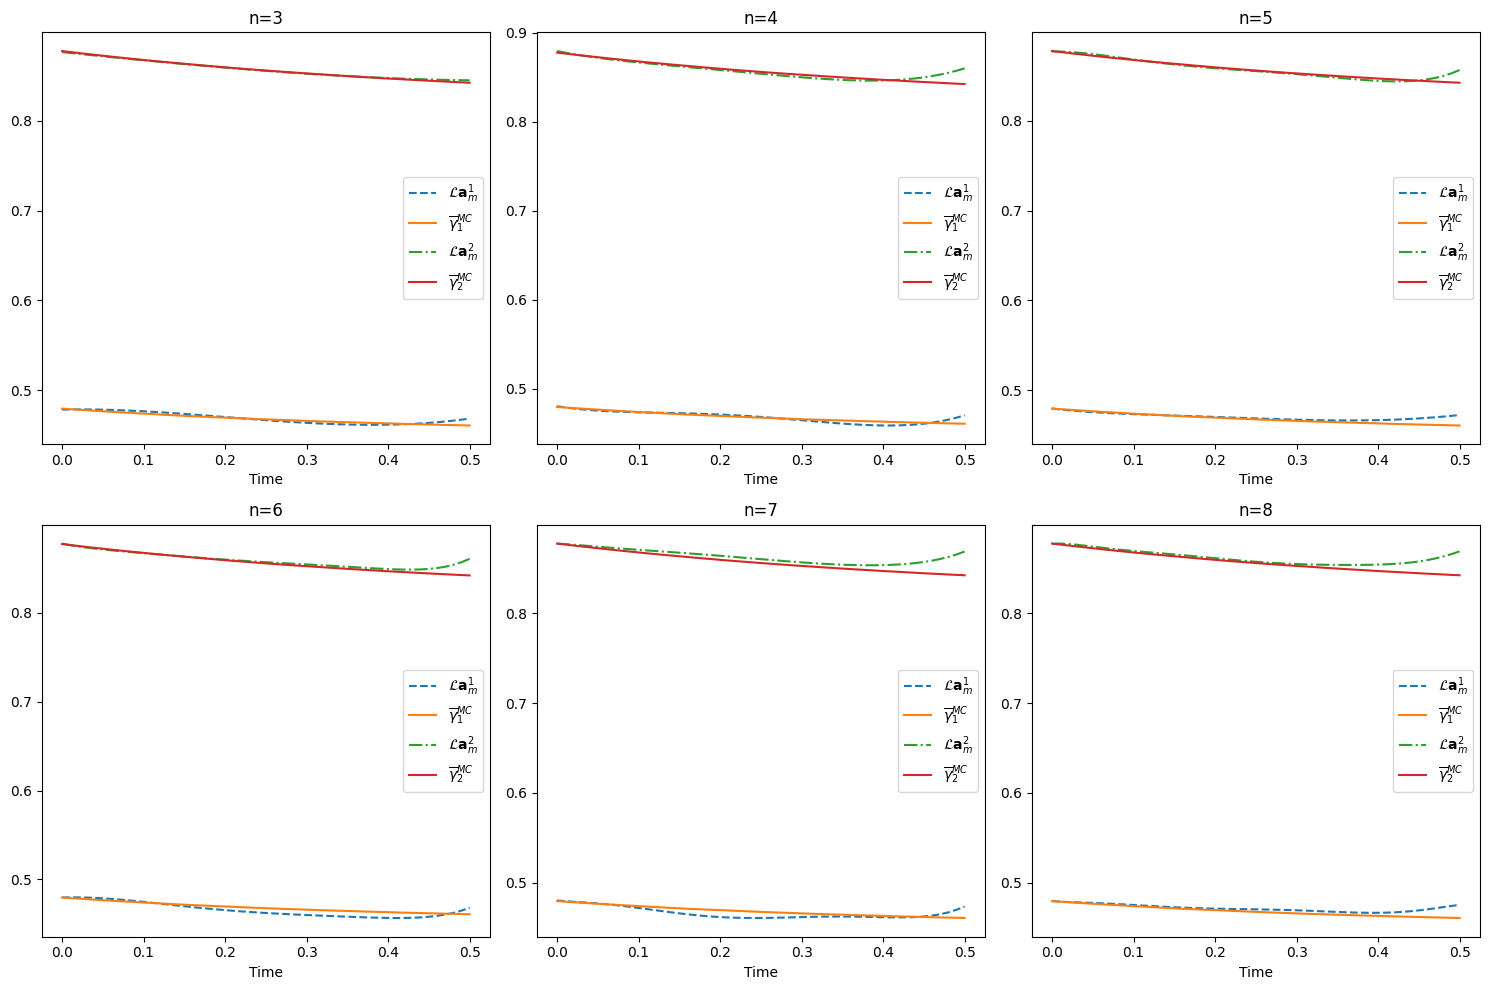

In [11]:
if __name__ == "__main__":

    sigma = 0.5
    X0 = 0.5
    M1 = 1000000
    tipo = 'lagrange'
    eps = 0.01

    T = 0.5   # 0.5, 1, 2, 4
    N = 50
    N1 = 50
    h = T / N
    n = [3, 4, 5, 6, 7, 8]
    r0 = [5, 5, 5, 5, 5, 5]
    rho = [0.7, 0.7, 0.7, 0.9, 0.9, 0.9]
    M = 1000

    # Euler - Monte Carlo

    start = time.process_time()   # the stopwatch starts
    X, gamma1, gamma2 = monte_carlo(sigma, T, N1, M1, X0)
    end = time.process_time()   # the stopwatch stops

    print("Euler - Monte Carlo execution time: ", end - start)
    print(" ")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 3 rows, 2 columns
    axes = axes.flatten()  # Flatten to iterate easily

    for i in range(6):
        a1_0, a2_0, g = base(T, N, n[i], X0, tipo)

        start = time.process_time()   # the stopwatch starts
        a1, a2, m = stochastic_gradient_descent(a1_0, a2_0, n[i], r0[i], rho[i], sigma, N, M, X0, eps, h, g, gamma1, gamma2)
        end = time.process_time()   # the stopwatch stops

        print("SGD execution time: ", end - start)
        print(" ")
        print("SGD steps: ", m)
        print(" ")

        ax = axes[i]  # Select the subplot
        ax.set_xlabel("Time")
        ax.plot(np.linspace(0, T, N+1), np.dot(a1, g), '--', label='$\mathcal{L}\mathbf{a}_m^1$')
        ax.plot(np.linspace(0, T, N+1), gamma1, label='$\overline{\gamma}^{MC}_1$')
        ax.plot(np.linspace(0, T, N+1), np.dot(a2, g), '-.', label='$\mathcal{L}\mathbf{a}_m^2$')
        ax.plot(np.linspace(0, T, N+1), gamma2, label='$\overline{\gamma}^{MC}_2$')
        ax.legend()
        ax.set_title(f"n={n[i]}")

    plt.tight_layout()
    plt.savefig("KSS_T05alln.pdf")
    plt.show()

#### $T=1$

Euler - Monte Carlo execution time:  2.873035113999997
 
SGD execution time:  0.08975044400000343
 
SGD steps:  6
 
SGD execution time:  0.0650470229999982
 
SGD steps:  4
 
SGD execution time:  0.0719883210000063
 
SGD steps:  4
 
SGD execution time:  0.06019922899999841
 
SGD steps:  3
 
SGD execution time:  0.08807141399999807
 
SGD steps:  4
 
SGD execution time:  0.07381760099999468
 
SGD steps:  3
 


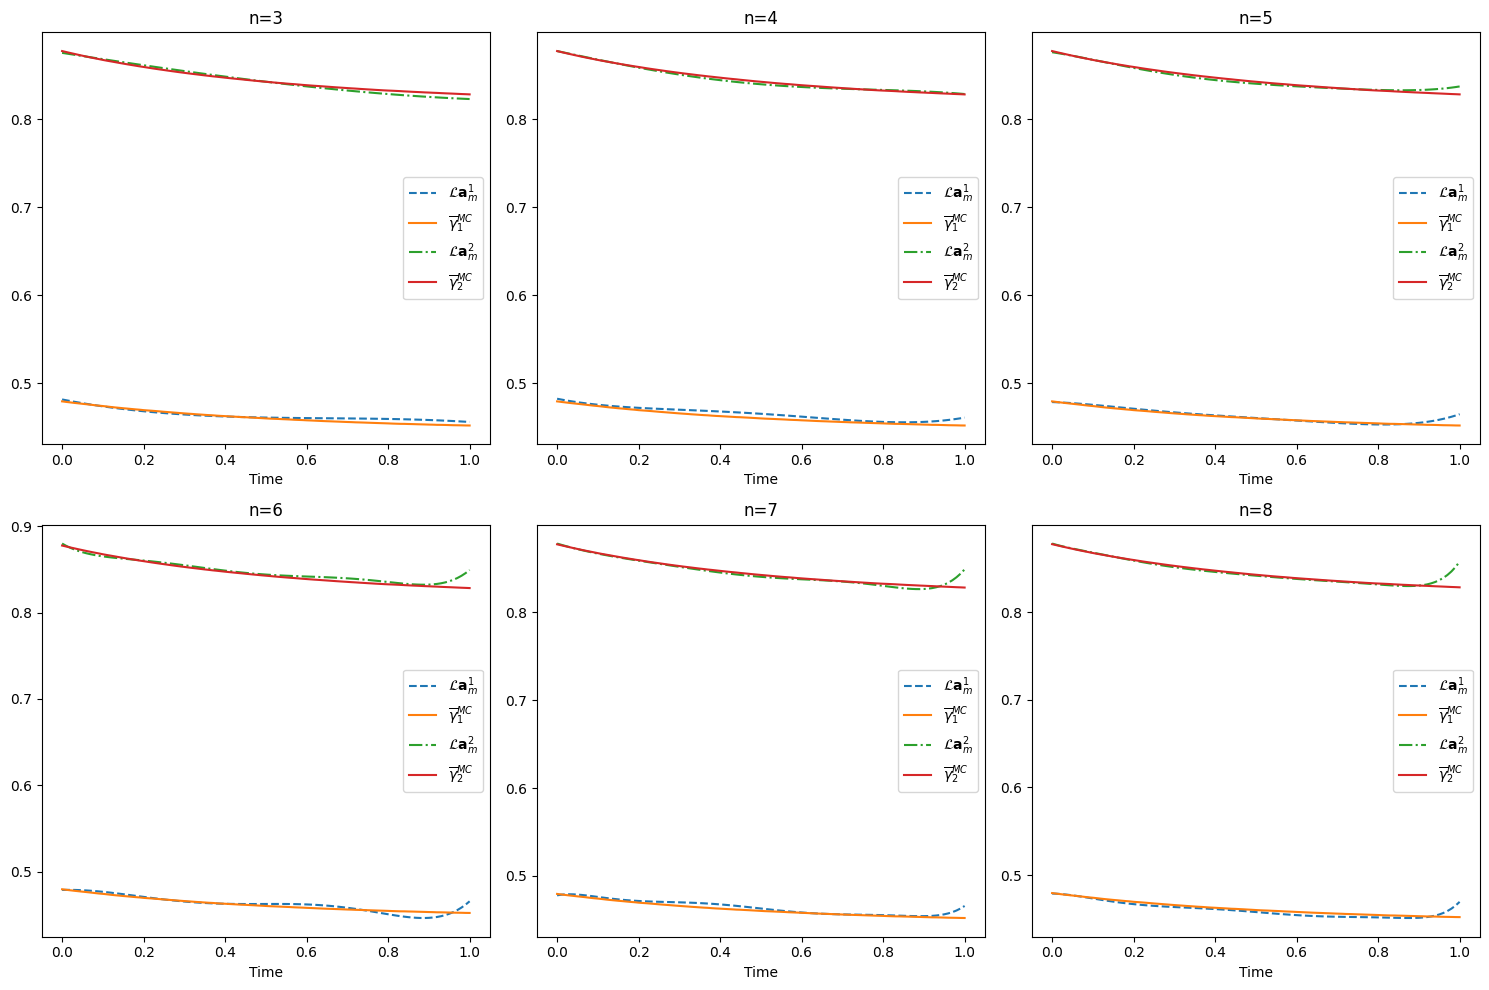

In [13]:
if __name__ == "__main__":

    sigma = 0.5
    X0 = 0.5
    M1 = 1000000
    tipo = 'lagrange'
    eps = 0.01

    T = 1   # 0.5, 1, 2, 4
    N = 100
    N1 = 100
    h = 0.01
    n = [3, 4, 5, 6, 7, 8]
    r0 = [5, 5, 5, 5, 5, 5]
    rho = [0.9, 0.9, 0.8, 0.9, 0.8, 0.9]
    M = 1000

    # Euler - Monte Carlo

    start = time.process_time()   # the stopwatch starts
    X, gamma1, gamma2 = monte_carlo(sigma, T, N1, M1, X0)
    end = time.process_time()   # the stopwatch stops

    print("Euler - Monte Carlo execution time: ", end - start)
    print(" ")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 3 rows, 2 columns
    axes = axes.flatten()  # Flatten to iterate easily

    for i in range(6):
        a1_0, a2_0, g = base(T, N, n[i], X0, tipo)

        start = time.process_time()   # the stopwatch starts
        a1, a2, m = stochastic_gradient_descent(a1_0, a2_0, n[i], r0[i], rho[i], sigma, N, M, X0, eps, h, g, gamma1, gamma2)
        end = time.process_time()   # the stopwatch stops

        print("SGD execution time: ", end - start)
        print(" ")
        print("SGD steps: ", m)
        print(" ")

        ax = axes[i]  # Select the subplot
        ax.set_xlabel("Time")
        ax.plot(np.linspace(0, T, N+1), np.dot(a1, g), '--', label='$\mathcal{L}\mathbf{a}_m^1$')
        ax.plot(np.linspace(0, T, N+1), gamma1, label='$\overline{\gamma}^{MC}_1$')
        ax.plot(np.linspace(0, T, N+1), np.dot(a2, g), '-.', label='$\mathcal{L}\mathbf{a}_m^2$')
        ax.plot(np.linspace(0, T, N+1), gamma2, label='$\overline{\gamma}^{MC}_2$')
        ax.legend()
        ax.set_title(f"n={n[i]}")

    plt.tight_layout()
    plt.savefig("KSS_T1alln.pdf")
    plt.show()

#### $T=2$

SGD execution time:  0.05227843399999976
 
SGD steps:  7
 


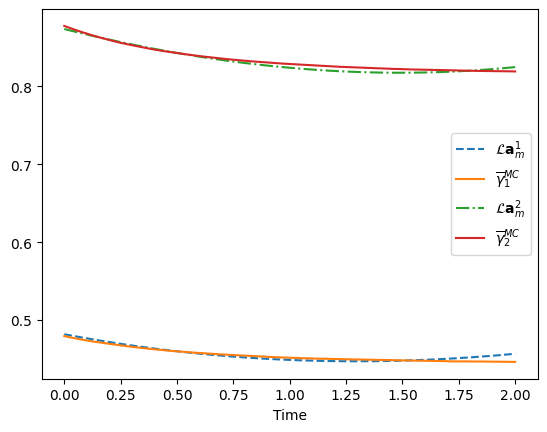

In [ ]:
if __name__ == "__main__":

    sigma = 0.5
    X0 = 0.5
    M1 = 1000000
    tipo = 'lagrange'
    eps = 0.01

    T = 2   # 0.5, 1, 2, 4
    N = 200
    N1 = 200
    h = 0.01
    n = [3, 4, 5, 6, 7, 8]
    r0 = [1, 1, 1, 1, 5, 5]
    rho = [0.6, 0.7, 0.6, 0.6, 0.8, 0.7]
    M = 1000

    # Euler - Monte Carlo

    start = time.process_time()   # the stopwatch starts
    X, gamma1, gamma2 = monte_carlo(sigma, T, N1, M1, X0)
    end = time.process_time()   # the stopwatch stops

    print("Euler - Monte Carlo execution time: ", end - start)
    print(" ")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 3 rows, 2 columns
    axes = axes.flatten()  # Flatten to iterate easily

    for i in range(6):
        a1_0, a2_0, g = base(T, N, n[i], X0, tipo)

        start = time.process_time()   # the stopwatch starts
        a1, a2, m = stochastic_gradient_descent(a1_0, a2_0, n[i], r0[i], rho[i], sigma, N, M, X0, eps, h, g, gamma1, gamma2)
        end = time.process_time()   # the stopwatch stops

        print("SGD execution time: ", end - start)
        print(" ")
        print("SGD steps: ", m)
        print(" ")

        ax = axes[i]  # Select the subplot
        ax.set_xlabel("Time")
        ax.plot(np.linspace(0, T, N+1), np.dot(a1, g), '--', label='$\mathcal{L}\mathbf{a}_m^1$')
        ax.plot(np.linspace(0, T, N+1), gamma1, label='$\overline{\gamma}^{MC}_1$')
        ax.plot(np.linspace(0, T, N+1), np.dot(a2, g), '-.', label='$\mathcal{L}\mathbf{a}_m^2$')
        ax.plot(np.linspace(0, T, N+1), gamma2, label='$\overline{\gamma}^{MC}_2$')
        ax.legend()
        ax.set_title(f"n={n[i]}")

    plt.tight_layout()
    plt.savefig("KSS_T2alln.pdf")
    plt.show()

## Tables

In [ ]:

experiment_name = "test"
parent_run_name = "Kuramoto model" 

# r0 = [[1, 1, 1, 1, 1], [5, 5, 1, 1, 1], [5, 5, 1, 1, 1], [1, 1, 1, 5, 5]]
# rho = [[0.7, 0.7, 0.7, 0.8, 0.7], [0.9, 0.9, 0.6, 0.7, 0.6], [0.9, 0.8, 0.7, 0.6, 0.6], [0.7, 0.6, 0.7, 0.9, 0.9]]

shared_params = {
    'T': 0.5, 'n':3, 'M':100, 'N':50, 'N1':100, 'sigma':0.5, 'X0':0.5, 'M1':1000000, 'h':0.01, 
    #'K':0, 'tau':5, 
    'r0':1, 'rho':0.6, 
    'eps':0.01, 'repetition':1, 'tipo':'lagrange',
    }

explored_params = {
    'K':[0,],
    'tau':[0,],
}

def main():

    experiment_id = set_experiment(experiment_name)

    args_list = [] 

    for vals in product(*list(explored_params.values())):
        params_subset = {key:val for key, val in zip(list(explored_params.keys()), vals)}
        params_arg = {**shared_params, **params_subset}
        run_name = '-'.join([f'{k}:{v}' for k, v in params_subset.items()])
        args = [run_name, experiment_name, params_arg]
        args_list.append(args)

    with mlflow.start_run(experiment_id=experiment_id, run_name=parent_run_name): # parent run       

        mlflow.log_params(shared_params)

        results = []
        for args in args_list:
            results.append(run(*args))

if __name__ == "__main__":
    main()

starting run "K:0-tau:0" ...
Euler - Monte Carlo execution time:  2.7815989820010145
 
... completed run "K:0-tau:0"!


In [ ]:
# #### MAIN 2

# if __name__ == "__main__":

#     # variable parameters
    
#     sigma = 0.5
#     X0 = 0.5
#     M1 = 1000000
#     tipo = 'lagrange'
#     eps = 0.01

#     T = 0.5   # 0.5, 1, 2, 4
#     N = 50
#     N1 = 50
#     h = T / N
    
#     n = 3 # [3, 4, 5, 6, 7, 8]

#     K_list = [0, 0.001, 0.0007, 0.0005, 0.0003]
#     tau_list = [0.1, 0.5, 1]
#     r0_list = [1, 5, 10]  
#     rho_list = [0.6, 0.7, 0.8, 0.9]
#     M_list = [1, 10, 100]
    
#     eps = 0.01
#     repetition = 10 # 1000
#     tipo = 'lagrange'
    
#     # Euler - Monte Carlo

#     start = time.process_time()   # the stopwatch starts
#     X, gamma1, gamma2 = monte_carlo(sigma, T, N1, M1, X0)
#     end = time.process_time()   # the stopwatch stops

#     print("Euler - Monte Carlo execution time: ", end - start)
#     print(" ")

#     # Stochastic Gradient Descent
#     with open("Tables T = "+str(T)+", n = "+str(n)+" and M = "+str(M_list)+".txt", "w") as f:

#         a1_0, a2_0, g = base(T, N, n, X0, tipo)

#         for M in M_list:

#             f.write("Number of iterations to achieve convergence with M = "+str(M)+" :")
#             f.write("\n")
#             f.write("\n")

#             m1 = np.zeros((len(K_list)*len(rho_list), len(tau_list)*len(r0_list)))
#             m2 = np.zeros((len(K_list)*len(rho_list), len(tau_list)*len(r0_list)))
#             m3 = np.zeros((len(K_list)*len(rho_list), len(tau_list)*len(r0_list)))

#             for i1, rho in enumerate(rho_list):
#                 for j1, r0 in enumerate(r0_list):

#                     for i2, K in enumerate(K_list):
#                         for j2, tau in enumerate(tau_list):

#                             start = time.process_time()   # the stopwatch starts
#                             mm = [stochastic_gradient_descent(a1_0, a2_0, n,r0, rho, sigma, N, M, X0, eps, h, g, gamma1, gamma2, K, tau) for _ in range(repetition)]
#                             end = time.process_time()   # the stopwatch stops
#                             m1[i1*len(K_list)+i2, j1*len(tau_list)+j2] = mean(mm)
#                             m2[i1*len(K_list)+i2, j1*len(tau_list)+j2] = min(mm)
#                             m3[i1*len(K_list)+i2, j1*len(tau_list)+j2] = max(mm)

#                             f.write(f"Time with r0={r0}, rho={rho}, tau={tau} and K={K}: {(end - start)/repetition}")
#                             f.write("\n")

#             f.write("\n")
#             f.write("\n")

#             headerslist = [f"r0={r0}\ntau={tau}" if tau == 0.5 else f"\ntau={tau}"for r0 in r0_list for tau in tau_list]
#             K_rho_headers =[f"rho={rho} K={K}" if K == 0 else f"K={K}"for rho in rho_list for K in K_list]

#             f.write(f"Average")
#             f.write(tabulate(np.column_stack((K_rho_headers, m1)), headers=headerslist, colalign=("right",)))
#             f.write("\n")
#             f.write("\n")

#             f.write(f"Min")
#             f.write(tabulate(np.column_stack((K_rho_headers, m2)), headers=headerslist, colalign=("right",)))
#             f.write("\n")
#             f.write("\n")

#             f.write(f"Max")
#             f.write(tabulate(np.column_stack((K_rho_headers, m3)), headers=headerslist, colalign=("right",)))
#             # print(tabulate(m[:,:], headers=headerslist, colalign=("right",), tablefmt="latex_raw"))
#             f.write("\n")
#             f.write("\n")

#         print("done M = "+str(M))